https://www.tensorflow.org/tutorials/generative/dcgan?hl=ja

In [1]:
"""from google.colab import drive
drive.mount('/content/drive/')"""

"from google.colab import drive\ndrive.mount('/content/drive/')"

In [2]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [4]:
import os, time, PIL, glob
import matplotlib.pyplot as plt

from IPython import display

from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

# GIF
import imageio

# データ準備

In [5]:
# MNIST import
(train_imgs, train_labels), (_, _) = mnist.load_data()

print(train_imgs.shape)
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32')
train_imgs = (train_imgs - 127.5) / 127.5
print(train_imgs.shape)

# 学習データセット作成
n_sample = train_imgs.shape[0]
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(n_sample).batch(batch_size)

# seedの設定
n_example = 16
noise_dim = 100
noise_shape = (noise_dim,)

seed = tf.random.normal([n_example, noise_dim])
print(seed.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)
(16, 100)


(256, 28, 28, 1)
(28, 28)


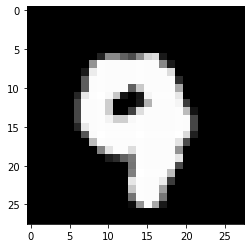

In [6]:
# 確認
def gen_dataset(dataset):
    while True:
        for imgs in train_dataset:
            yield imgs

batch_gen = gen_dataset(train_dataset)
batch_imgs = next(batch_gen)

print(batch_imgs.shape)
batch_imgs = batch_imgs[0, :, :, 0]
print(batch_imgs.shape)

plt.imshow(batch_imgs, cmap='gray')

#モデル構築


In [7]:
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=noise_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,  activation='tanh'))
    
    return model

In [8]:
g = build_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

(32, 28, 28, 1)


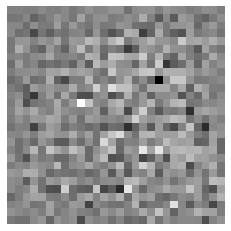

In [9]:
# test
noise = tf.random.normal([32, noise_dim])   # tf.random.normal(shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None)
gen_img = g(noise, training=False)
print(gen_img.shape)

plt.axis('off')
plt.imshow(gen_img[0, :, :, 0], cmap='gray')    # cmap: 色指定

In [10]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [11]:
d = build_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [12]:
# test
d(gen_img)

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-3.6384226e-04],
       [ 1.7078075e-03],
       [-1.8246993e-03],
       [-3.3673347e-04],
       [ 1.3905852e-03],
       [ 7.1571802e-04],
       [ 1.1191500e-03],
       [ 2.0702530e-03],
       [-1.7926552e-03],
       [-7.1919632e-05],
       [ 1.0761976e-03],
       [-2.4917894e-03],
       [-1.9845522e-03],
       [ 7.2344346e-04],
       [ 2.2920163e-03],
       [-1.3479623e-03],
       [-1.5497868e-03],
       [-5.4827705e-04],
       [-7.9767173e-04],
       [-2.4087385e-03],
       [-2.2599548e-03],
       [-7.3403737e-04],
       [ 1.9352019e-03],
       [-1.0719730e-03],
       [ 1.3933139e-03],
       [ 1.4093255e-03],
       [ 4.1405665e-04],
       [ 6.1995233e-04],
       [-2.1973108e-03],
       [-1.6422212e-04],
       [ 9.5457712e-04],
       [ 6.4044714e-04]], dtype=float32)>

In [13]:
# 共通の損失
cross_entropy = losses.BinaryCrossentropy(from_logits=True) # from_logits: 予測値がbinary値のときTrue、確率のときFalse


# generatorの損失
def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# discriminatorの損失
def d_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [14]:
# optimizer
g_optimizer = Adam(10**-4)
d_optimizer = Adam(10**-4)

#checkpoint

In [15]:
# checkpoint
checkpoint_dir = '/content/check_points'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')    # file名の接頭語
print(checkpoint_prefix)    

checkpoint = tf.train.Checkpoint(
        generator_optimizer = g_optimizer,
        descriminator_optimizer = d_optimizer,
        generator = g,
        discriminator = d
)

/content/check_points/ckpt


# 学習

In [16]:
# 1batch分の学習の関数
@tf.function    # ???
def train_step(imgs):
    noise = tf.random.normal([batch_size, noise_dim])                   # batch_size分のnoise生成

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:                                     # 開始と終了を必要とする処理, with内の演算の勾配を記録
        gen_imgs = g(noise, training=True)                              # noiseからbatch_size枚の画像(gen_imgs)生成

        real_output = d(imgs, training=True)                            # real画像の予測
        fake_output = d(gen_imgs, training=True)                      # fake画像の予測

        gen_loss = g_loss(fake_output)                                  # fakeの予測結果と正解ラベル(全部1)からloss算出
        disc_loss = d_loss(real_output, fake_output)                    # 「fakeの予測結果と正解ラベル0」&「realの予測結果と正解ラベル1」からloss算出

    # 勾配取得
    grad_gen = gen_tape.gradient(gen_loss, g.trainable_variables)           # gen_lossから各種パラメータの勾配算出
    grad_disc = disc_tape.gradient(disc_loss, d.trainable_variables)         # disc_lossから各種パラメータの勾配算出

    # 勾配をoptimizerに適用してパラメータ更新
    d_optimizer.apply_gradients(zip(grad_disc, d.trainable_variables))
    g_optimizer.apply_gradients(zip(grad_gen, g.trainable_variables))


def show_and_save(
        model,          # その時点での学習済みモデル
        epoch,          # ファイル名用にepoch取得
        test_input):    # モデルに入力するテストデータ

    imgs = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))

    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(imgs[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')

    os.makedirs('/content/imgs', exist_ok=True)
    plt.savefig('/content/imgs/img@epoch_{:04d}.png'.format(epoch))
    plt.show()



def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:   # 1epoch分学習
            train_step(img_batch)

        display.clear_output(wait=True)        

        show_and_save(g, epoch+1, seed) # 現段階のgeneratorの画像を出力&保存

        if (epoch + 1) % 20 == 0:   # 15epochに1回モデル保存
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    display.clear_output(wait=True)

    show_and_save(g, epochs, seed)   # 学習の最後に保存

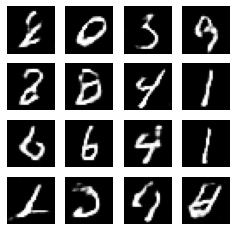

In [17]:
# 学習の定義
epochs = 100
train(train_dataset, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# GIF化

In [18]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/content/imgs/img@epoch_{:04d}.png'.format(epoch_no))


anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/imgs/img*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [19]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ggt4k925
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ggt4k925
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157706 sha256=335c4b76ca776c8f192b8a0405320758d1c5b594f3857b7c563596b98e6efd96
  Stored in directory: /tmp/pip-ephem-wheel-cache-_w41g_ez/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [20]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.